## AdaBoost From Scratch - Oded Ben Chetrit


*   Implemented AdaBoost algorithm for classification task.
*   Used 2 types of weak learners - SVM and tree stamp.
*   I created a synthetic dataset to train and test the algorithm. 


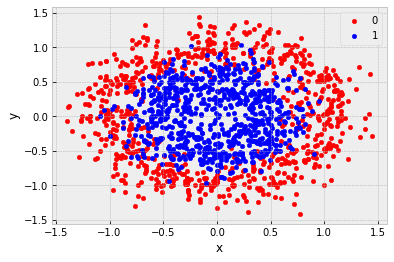

In [4]:
from sklearn.datasets import make_circles
from matplotlib import pyplot
from pandas import DataFrame

# generate 2d classification dataset
X, y = make_circles(n_samples=1500, noise=0.2, random_state=101, factor=0.5)

# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [5]:
# Helper function to preprocess the data:
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
def process_data(df):
    X = df[['x','y']].values
    y = df['label'].values
    y[y == 0] = -1
    return X, y

# Apply preprocessing:
X,y = process_data(df)

In [6]:
class ADA_Boost():
    def __init__(self, X, y, T, model = 'SVM'):
        
        # Assign data:
        self.X = X
        self.y = y
        
        # number of samples:
        self.n = self.X.shape[0]
        
        # initialize weights:
        self.w = np.ones(self.n)/self.n
        
        # number of features: 
        self.n_features = self.X.shape[1]  
        
        # number of weak learners (models):
        self.T = T
        
        # Chosen weak learner model: 
        self.model = model
        
    # Helper function to compute Gini impurity:
    def gini_impurity(self, y_preds):
        
        # True Positive:
        TP = np.sum((self.y == 1) == (y_preds == 1))
        
        # True Negative:
        TN = np.sum((self.y != 1) == (y_preds != 1))
        
        # False Positive:
        FP = np.sum((self.y != 1) == (y_preds == 1))
        
        # False Negative: 
        FN = np.sum((self.y == 1) == (y_preds != 1))
        
        # Compute Gini impurity:
        g1 = 1 - (TP/(TP + FP))**2 - (FP/(TP + FP))**2
        
        g2 = 1 - (TN/(TN + FN))**2 - (FN/(TN + FN))**2
        
        gini = g1 * ((TP + FP) / (TP + FP + TN + FN)) + g2 * ((TP + FP) / (TP + FP + TN + FN))
        
        return gini
    
    # Helper function to compute the total error:
    def tot_error(self, y_preds):
        
        return np.sum(self.w[self.y != y_preds])
    
    # Helper function to compute the amount of say for each weak learner: 
    def amount_of_say(self, eps):
        
        return 0.5 * np.log((1 - eps) / eps)
    
    def update_weights(self, y_preds, aos):

        self.w[self.y != y_preds] = self.w[self.y != y_preds] * np.exp(aos)

        self.w[self.y == y_preds] = self.w[self.y == y_preds] * np.exp(-aos)

        self.w = self.w / np.sum(self.w)
    
    def resample(self):
        cumsum = np.expand_dims(np.cumsum(self.w), 1)

        # randomly select n random values between 0:1: 
        a = np.random.rand(1, self.n)

        # obtain indecies of selected fitness values: 
        ind = np.sum(a > cumsum, axis =0)
        
        # initialize sample weights:
        self.w = np.ones(self.n)/self.n
        
        # Resample Data: 
        self.X = self.X[ind,:]     
        self.y = self.y[ind]
        
    def select_feature(self):
        
        # initialize min gain:
        min_gain = 1
        
        # Run over all features to select feature:
        for feature in range(self.n_features):
            
            # define weak learner - here we use an SVM classifier:
            if self.model == 'SVM':
                weak_learner = LinearSVC()
                
            elif self.model == 'Stamp':
                weak_learner = DecisionTreeClassifier(max_depth = 1)
                
            # Select column from X as feature:
            X_feature = self.X[:,feature].reshape(-1, 1)
            
            # fit and predict the weak learner with the feature:
            weak_learner.fit(X_feature, self.y)
            y_preds_feature = weak_learner.predict(X_feature)
            
            # Compute the Gini impurity gain:
            gain = self.gini_impurity(y_preds_feature)
 
            # Select the feature with the lowest gain and update gain:
            if min_gain > gain:
                min_gain = gain
                selected_feature = feature
                y_preds = y_preds_feature
                selected_weak_learner = weak_learner
                
        return selected_feature, y_preds, selected_weak_learner
    
    def fit(self):
        self.ada_dic = {}
        for t in range(self.T):
            # Select feature and fit a weak learner  
            selected_feature, y_preds, selected_weak_learner = self.select_feature()
            
            # Compute total error:
            eps = self.tot_error(y_preds)
            
            # Compute Amount of say:
            aos = self.amount_of_say(eps)
            
            # Update Weights:
            self.update_weights(y_preds, aos)
            
            # Resample Data:
            self.resample()
            
            # Store in dictionary:
            self.ada_dic[t] = {'model' : selected_weak_learner,
                          'feature' : selected_feature,
                         'amount of say' : aos}
        
    def predict(self, X):
        
        # Create an empty matrix in the size of number of weak learners x number of test samples:
        preds_aos = np.zeros((self.T, X.shape[0]))
        
        # Run over all weak learners: 
        for t in self.ada_dic.keys():
            
            # Retrieve properties from dictionary: 
            weak_learner = ada.ada_dic[t]['model']
            feature = ada.ada_dic[t]['feature']
            aos = ada.ada_dic[t]['amount of say']
            X_feature = X[:,feature].reshape(-1, 1)
            
            # Multipile weaklearner prediction with it's amount of say:
            preds_aos[t] = weak_learner.predict(X_feature)*aos
        
        # Sum up all waighted predictions: 
        preds = np.sum(preds_aos,0)
        
        # positive preds assigned as 1, negative preds assigned as -1:
        preds[preds > 0] = 1
        preds[preds < 0] = -1
        
        return preds

#### Run the Ada boost algorithm with weak learner of type - SVM:

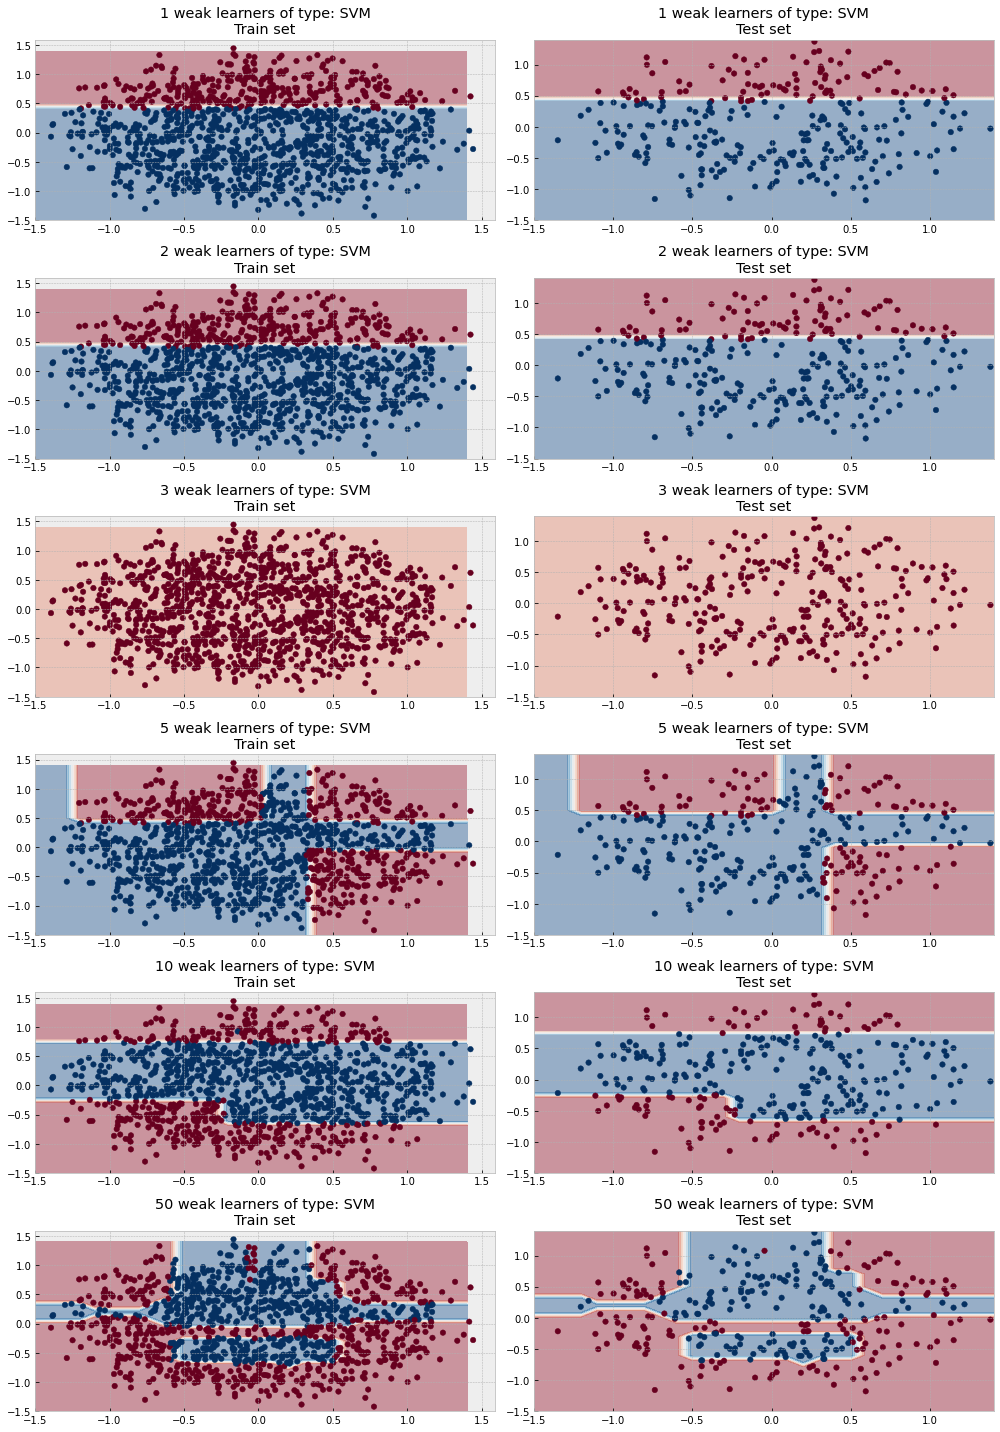

In [7]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
plt.style.use('bmh')
# Define contour borders: 
x_min = -1.5
y_min = -1.5
x_max = 1.5
y_max = 1.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
        
plt.figure(figsize = (14,20))
i=1
train_err = []
test_err = []

for n in [1,2,3,5,10,50]:
        
    ada = ADA_Boost(X_train, y_train, T = n, model = 'SVM')
    ada.fit()
    y_preds = ada.predict(X_train)
    
    train_err.append(1 - np.sum(y_preds == y_train) / len(y_train))
    
    Z = ada.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.subplot(6,2,i)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu")
    plt.scatter(X_train[:, 0], X_train[:, 1], c = y_preds, s=30, cmap="RdBu")
    plt.title(f'{n} weak learners of type: SVM\nTrain set') 
    
    i += 1
    y_preds = ada.predict(X_test)
    
    test_err.append(1 - np.sum(y_preds == y_test) / len(y_test))
    
    plt.subplot(6,2,i)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu")
    plt.scatter(X_test[:, 0], X_test[:, 1], c = y_preds, s=30, cmap="RdBu")
    plt.title(f'{n} weak learners of type: SVM\nTest set') 


    i += 1
plt.tight_layout()
plt.show()

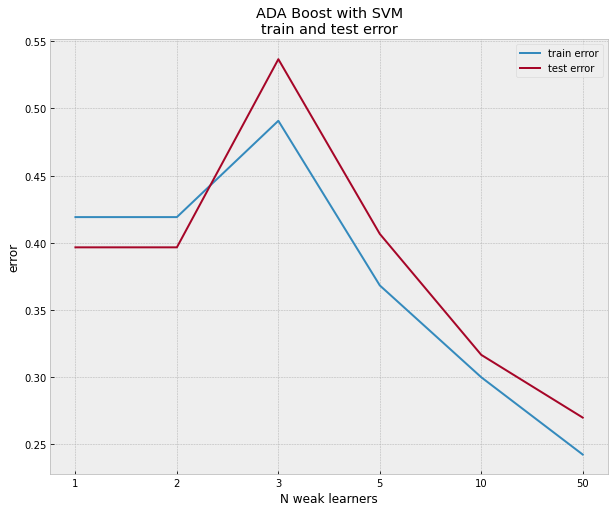

In [8]:
plt.figure(figsize = (10,8))
plt.plot(train_err, label = 'train error')
plt.plot(test_err, label = 'test error')
plt.title('ADA Boost with SVM\ntrain and test error')
plt.xlabel('N weak learners')
plt.ylabel('error')
plt.legend()
plt.xticks([0,1,2,3,4,5],['1','2','3','5','10','50'])
plt.show()

#### Run the Ada boost algorithm with weak learner of type - Tree Stamp:

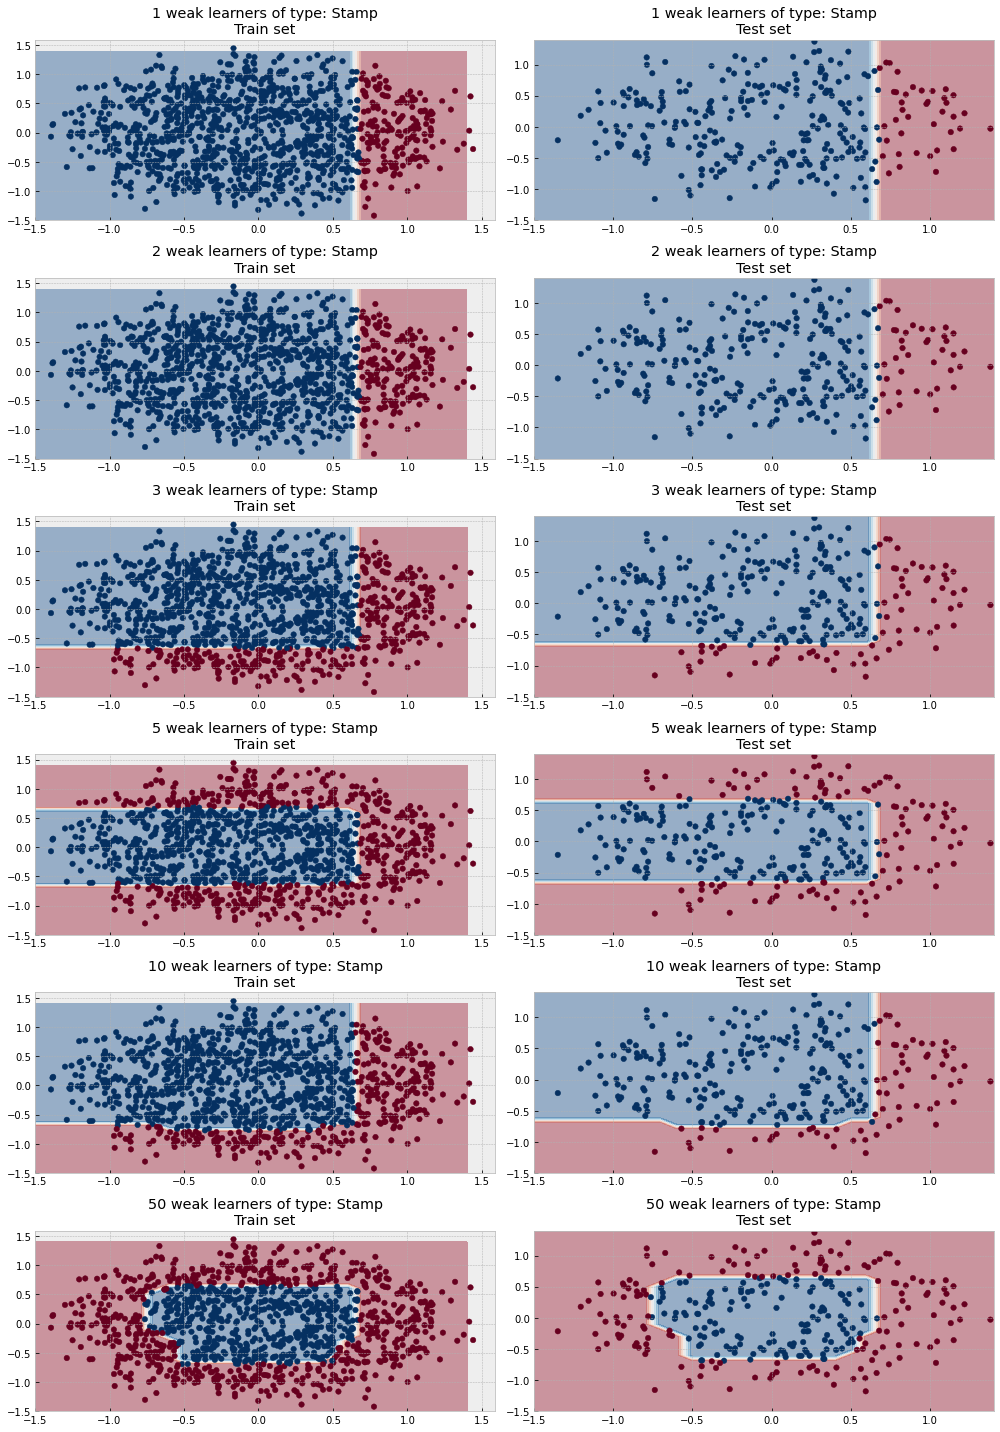

In [9]:
plt.figure(figsize = (14,20))
i=1

train_stamp_err = []
test_stamp_err = []

for n in [1,2,3,5,10,50]:
        
    ada = ADA_Boost(X_train, y_train, T = n, model = 'Stamp')
    ada.fit()
    y_preds = ada.predict(X_train)
    
    train_stamp_err.append(1 - np.sum(y_preds == y_train) / len(y_train))
    
    Z = ada.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.subplot(6,2,i)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu")
    plt.scatter(X_train[:, 0], X_train[:, 1], c = y_preds, s=30, cmap="RdBu")
    plt.title(f'{n} weak learners of type: Stamp\nTrain set') 
    
    i += 1
    y_preds = ada.predict(X_test)
    
    test_stamp_err.append(1 - np.sum(y_preds == y_test) / len(y_test))

    plt.subplot(6,2,i)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu")
    plt.scatter(X_test[:, 0], X_test[:, 1], c = y_preds, s=30, cmap="RdBu")
    plt.title(f'{n} weak learners of type: Stamp\nTest set') 


    i += 1
plt.tight_layout()
plt.show()

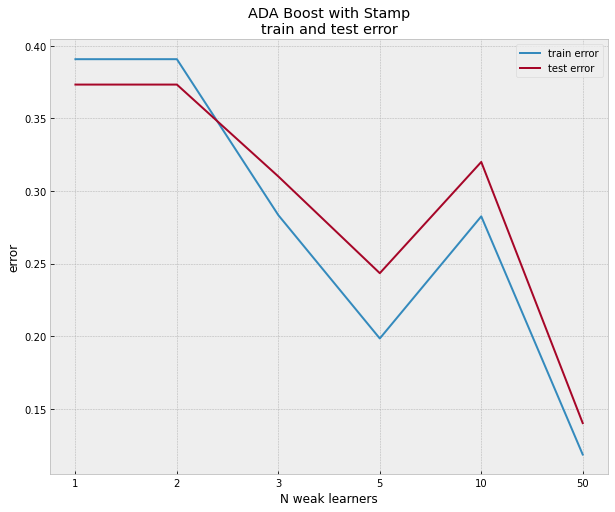

In [10]:
plt.figure(figsize = (10,8))
plt.plot(train_stamp_err, label = 'train error')
plt.plot(test_stamp_err, label = 'test error')
plt.title('ADA Boost with Stamp\ntrain and test error')
plt.xlabel('N weak learners')
plt.ylabel('error')
plt.legend()
plt.xticks([0,1,2,3,4,5],['1','2','3','5','10','50'])
plt.show()